In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/

Mounted at /content/gdrive
/content/gdrive/MyDrive


In [3]:
target_path = "mps/HP_mosaic_random_size8x8_image64+10+500_alternate.npz"
collected_path = "mps/HP+mosaic+rand_image64+10+500_size8x8_alternate_200x20020240618_collect.npz"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### utils

In [4]:
def load_data(target_data_path, collected_data_path):
    """
    Input:
    data_path
    Output:
    target_data, collected_data
    """
    target_data = np.load(target_data_path)["arr_0"]
    collected_data = np.load(collected_data_path)["arr_0"]
    # print("Target data shape:", target_data.shape)
    # print("Collected_data shape:", collected_data.shape)
    return target_data, collected_data


def hadamard_total(target_data_path, collected_data_path):
    """
    Input:
    data_path
    Output:
    target_hadamard, collected_hadamard
    """
    target_data, collected_data = load_data(target_data_path, collected_data_path)
    target_hadamard = target_data[:128, :]
    collected_hadamard = collected_data[:128, :]

    # 取得データのうち偶数列のみを取り出す(0, 2, 4, 6...998)
    collected_hadamard = collected_hadamard[:, ::2]

    # 色反転の差をとる
    target_hadamard_total = target_hadamard[0::2, :] - target_hadamard[1::2, :]
    collected_hadamard_total = collected_hadamard[0::2, :] - collected_hadamard[1::2, :]
    # print("Target Hadamard shape:", target_hadamard_total.shape)
    # print("Collected Hadamard shape:", collected_hadamard_total.shape)
    return target_hadamard_total, collected_hadamard_total


def random_total(target_data_path, collected_data_path):
    """
    Input:
    data_path
    Output:
    target_random, collected_random
    """
    target_data, collected_data = load_data(target_data_path, collected_data_path)
    target_random = target_data[148:, :]
    collected_random = collected_data[148:, :]

    # 取得データのうち偶数列のみを抽出する(0, 2, 4, 6...998)
    collected_random = collected_random[:, ::2]

    # 色反転の差をとってまとめる
    target_random_total = target_random[0::2, :] - target_random[1::2, :]
    collected_random_total = collected_random[0::2, :] - collected_random[1::2, :]
    # print("Target Random shape:", target_random_total.shape)
    # print("Collected Random shape:", collected_random_total.shape)
    return target_random_total, collected_random_total


def mnist_total(target_data_path, collected_data_path):
    """
    Input:
    data_path
    Output:
    target_mnist, collected_mnist
    """
    target_data, collected_data = load_data(target_data_path, collected_data_path)
    target_mnist = target_data[128:148, :]
    collected_mnist = collected_data[128:148, :]

    # 取得データのうち偶数列のみを抽出する(0, 2, 4, 6...998)
    collected_mnist = collected_mnist[:, ::2]
    target_mnist_total = target_mnist[0::2, :] - target_mnist[1::2, :]
    collected_mnist_total = collected_mnist[0::2, :] - collected_mnist[1::2, :]
    # print("Target mnist shape:", target_mnist_total.shape)
    # print("Collected mnist shape:", collected_mnist_total.shape)
    return target_mnist_total, collected_mnist_total


def inverse_hadamard(target, collected):
    """
    Input:
    hadamard_data
    Output:
    Speckle matrix from inversed Hadamard matrix
    """
    n = int(target.shape[0])
    hadamard_speckle_matrix = np.dot(collected.T, target.T) / n
    # print("Hadamard Speckle matrix shape:", hadamard_speckle_matrix.shape)
    return hadamard_speckle_matrix


def random_pattern_split(target_random, collected_random, test_size=0.1, shuffle=False):
    """
    Input:
    target_random, collected_random
    test-size:0-1
    shuffle:True or False
    Output:
    Target_train, Target_test, Collected_train, Collected_test

    """
    X_train, X_test, y_train, y_test = train_test_split(
        target_random, collected_random, test_size=test_size, shuffle=shuffle
    )
    return X_train, X_test, y_train, y_test


# =====================================================================
# Speckle Noise Calculation by Ridge Regression
# =====================================================================
def speckle_noise_calculation(target_random, collected_random, S, alpha=1):
    """
    Target Random and Collected_random are generated by the function "random_pattern_split"
    """
    # _, X_train2, _, y_train2 = random_pattern_split()
    # X_train1, _, y_train1, _ = random_pattern_split()
    delta = collected_random - np.dot(target_random, S.T)
    delta_Ridge = Ridge(alpha=alpha)
    delta_Ridge.fit(target_random, delta)
    delta_ridge_coef = delta_Ridge.coef_
    predicted_speckle = S + delta_ridge_coef
    # speckle.shape: (500, 64)
    return predicted_speckle


# =====================================================================
# Loss Functions
# =====================================================================

def normal_loss(y_pred, y_true, S):
    # Calcurate y from predicted x and S
    reconstructed_y = torch.mm(y_pred.unsqueeze(0), S).squeeze(0)
    # Calculate MSE loss at original scale
    loss = F.mse_loss(reconstructed_y, y_true)
    return loss

def multiscale_loss(y_pred, y_true, S, weight):
    # Reconstruct y from predicted x
    reconstructed_y = torch.mm(y_pred.unsqueeze(0), S).squeeze(0)

    # Calculate MSE loss at original scale
    loss = F.mse_loss(reconstructed_y, y_true)

    # Calculate loss at lower resolution
    # Ensure inputs are 3D for avg_pool1d
    y_pred_3d = reconstructed_y.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 500)
    y_true_3d = y_true.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 500)

    # Apply average pooling with appropriate kernel size and stride
    kernel_size = 4
    y_pred_low = torch.avg_pool1d(
        y_pred_3d, kernel_size=kernel_size, stride=kernel_size
    ).squeeze()
    y_true_low = torch.avg_pool1d(
        y_true_3d, kernel_size=kernel_size, stride=kernel_size
    ).squeeze()

    # Add low-resolution loss
    loss += weight * F.mse_loss(y_pred_low, y_true_low)

    return loss

# def multiscale_mae_loss(y_pred, y_true, S):
#     # Reconstruct y from predicted x
#     reconstructed_y = torch.mm(y_pred.unsqueeze(0), S).squeeze(0)

#     # Calculate MSE loss at original scale
#     loss = F.l1_loss(reconstructed_y, y_true)

#     # Calculate loss at lower resolution
#     # Ensure inputs are 3D for avg_pool1d
#     y_pred_3d = reconstructed_y.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 500)
#     y_true_3d = y_true.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 500)

#     # Apply average pooling with appropriate kernel size and stride
#     kernel_size = 4
#     y_pred_low = torch.avg_pool1d(
#         y_pred_3d, kernel_size=kernel_size, stride=kernel_size
#     ).squeeze()
#     y_true_low = torch.avg_pool1d(
#         y_true_3d, kernel_size=kernel_size, stride=kernel_size
#     ).squeeze()

#     # Add low-resolution loss
#     loss += 1 * F.l1_loss(y_pred_low, y_true_low)

#     return loss

### Models

In [5]:
class Net_version_1(nn.Module):
    def __init__(self):
        super(Net_version_1, self).__init__()
        self.fc1 = nn.Linear(500, 250)
        self.fc2 = nn.Linear(250, 64)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return x

In [13]:
class UNet_ver2(nn.Module):
    """
    Unet-based original model
    """

    def __init__(self):
        super(UNet_ver2, self).__init__()
        # Encoder
        self.down1 = self.down_sample(1, 32)
        self.down2 = self.down_sample(32, 64)
        self.down3 = self.down_sample(64, 128)

        # Decoder
        self.up3 = self.up_sample(128, 64)
        self.up2 = self.up_sample(128, 32)
        self.up1 = self.up_sample(64, 16)
        self.fc = nn.Sequential(
            nn.Linear(16 * 500, 512),
            # nn.LeakyReLU(0.2),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            # nn.LeakyReLU(0.2),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(256, 64),
            nn.Tanh()
        )

    def down_sample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
        )

    def up_sample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose1d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch_size, 1, 500)

        # Encoder
        d1 = self.down1(x)  # (batch_size, 32, 250)
        d2 = self.down2(d1)  # (batch_size, 64, 125)
        d3 = self.down3(d2)  # (batch_size, 128, 63)

        # Decoder
        u3 = self.up3(d3)  # (batch_size, 64, 126)
        u3 = torch.cat([u3[:, :, :125], d2], dim=1)  # (batch_size, 128, 125)

        u2 = self.up2(u3)  # (batch_size, 32, 250)
        u2 = torch.cat([u2, d1], dim=1)  # (batch_size, 64, 250)

        u1 = self.up1(u2)  # (batch_size, 16, 500)

        # Flatten and pass through fully connected layers
        out = self.fc(u1.view(u1.size(0), -1))  # (batch_size, 64)
        return out

In [14]:
class UNetAdvanced_ver2(nn.Module):
    def __init__(self):
        super(UNetAdvanced_ver2, self).__init__()

        # Contracting path (Down-sampling)
        self.conv1 = self.conv_block(1, 64, 64)
        self.down1 = self.down_sampling()
        self.conv2 = self.conv_block(64, 128, 128)
        self.down2 = self.down_sampling()
        self.conv3 = self.conv_block(128, 256, 256)
        self.down3 = self.down_sampling()
        self.conv4 = self.conv_block(256, 512, 512)
        self.down4 = self.down_sampling()
        self.conv5 = self.conv_block(512, 1024, 1024)

        # Expanding path (Up-sampling)
        self.up1 = self.up_sampling(1024, 512)
        self.conv6 = self.conv_block(1024, 512, 512)
        self.up2 = self.up_sampling(512, 256)
        self.conv7 = self.conv_block(512, 256, 256)
        self.up3 = self.up_sampling(256, 128)
        self.conv8 = self.conv_block(256, 128, 128)
        self.up4 = self.up_sampling(128, 64)
        self.conv9 = self.conv_block(128, 64, 64)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(64 * 496, 1024),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.Tanh()
        )

    def conv_block(self, in_channels, middle_channels, out_channels):
        # Convolutional block with BatchNorm and ReLU activation
        return nn.Sequential(
            nn.Conv1d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(middle_channels),
            nn.Tanh(),
            nn.Conv1d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.Tanh(),
        )

    def down_sampling(self):
        # Max-pooling layer for down-sampling
        return nn.MaxPool1d(kernel_size=2)

    def up_sampling(self, in_channels, out_channels):
        # Up-sampling layer using Upsample and Conv1d
        return nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.BatchNorm1d(in_channels),
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
        )

    def forward(self, x):
        # Contracting path
        x = x.unsqueeze(1)
        r1 = self.conv1(x)
        d1 = self.down1(r1)
        r2 = self.conv2(d1)
        d2 = self.down2(r2)
        r3 = self.conv3(d2)
        d3 = self.down3(r3)
        r4 = self.conv4(d3)
        d4 = self.down4(r4)
        r5 = self.conv5(d4)

        # Expanding path
        u1 = self.up1(r5)
        out1 = torch.cat((u1, r4), dim=1)
        out1 = self.conv6(out1)
        u2 = self.up2(out1)
        out2 = torch.cat([u2, r3[:, :, :124]], dim=1)
        out2 = self.conv7(out2)
        u3 = self.up3(out2)
        out3 = torch.cat([u3, r2[:, :, :248]], dim=1)
        out3 = self.conv8(out3)
        up4 = self.up4(out3)
        out4 = torch.cat([up4, r1[:, :, :496]], dim=1)
        out4 = self.conv9(out4)

        # Fully connected layers and final activation
        out5 = self.fc(out4.view(out4.size(0), -1))
        return out_5

### training

In [15]:
######################################################
# Training function
######################################################
def train_model(
    model: nn.Module,
    speckle: torch.Tensor,
    input_data: torch.Tensor,
    num_epochs: int,
    learning_rate: float,
):
    model.to(device)
    input_data = input_data.to(device)
    speckle = speckle.T.to(device)
    optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

    loss_list = []
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        reconstructed_mnist = model(input_data.unsqueeze(0)).squeeze(0)
        loss = normal_loss(reconstructed_mnist, input_data, speckle)
        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())

        if (epoch + 1) % 100 == 0:
            print(f"Epoch: [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")
    model.eval()
    with torch.no_grad():
        reconstucted_target = model(input_data.unsqueeze(0)).squeeze(0)

    return loss_list, reconstucted_target

In [10]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.6 MB/s eta 0:00:00


In [16]:
import optuna

# 最適な reconstructed_total、学習率、エポック数を保持する変数を定義
best_reconstructed_total = None
best_learning_rate = None
best_num_epochs = None

def objective(trial):
    global best_reconstructed_total, best_learning_rate, best_num_epochs  # グローバル変数として定義

    # ハイパーパラメータの探索
    num_epochs = trial.suggest_int("num_epochs", 3000, 10000)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-3)

    # モデルのインスタンス化
    model = UNet_ver2()
    model.to(device)

    # データのロード
    target_hadamard, collected_hadamard = hadamard_total(target_path, collected_path)
    target_mnist, collected_mnist = mnist_total(target_path, collected_path)
    target_random, collected_random = random_total(target_path, collected_path)
    X_train, _, y_train, _ = random_pattern_split(target_random, collected_random, test_size=0.1, shuffle=False)
    hadamard_speckle_matrix = inverse_hadamard(target_hadamard, collected_hadamard)
    predicted_speckle = speckle_noise_calculation(X_train, y_train, S=hadamard_speckle_matrix, alpha=1)
    predicted_speckle = torch.tensor(predicted_speckle).float().to(device)

    # 学習と再構成
    loss_total = []
    reconstructed_total = []
    for i in range(collected_mnist.shape[0]):
        collected_mnist_i = torch.tensor(collected_mnist[i]).float().to(device)
        loss, reconstructed_target = train_model(
            model=model,
            speckle=predicted_speckle,
            input_data=collected_mnist_i,
            num_epochs=num_epochs,
            learning_rate=learning_rate
        )
        loss_total.append(loss)
        reconstructed_total.append(reconstructed_target.cpu())  # CPUに移動

    # 目的関数としてMSEを計算
    mse_val = mean_squared_error(target_mnist, [r.numpy() for r in reconstructed_total])

    # 最良の結果を更新
    if trial.number == 0 or mse_val < trial.study.best_value:
        best_reconstructed_total = reconstructed_total
        best_learning_rate = learning_rate
        best_num_epochs = num_epochs

    return mse_val

In [17]:
# Optunaで最適化を実行
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1)

# 最適なハイパーパラメータと再構成結果を出力
# print(f"Best reconstructed total: {best_reconstructed_total}")
print(f"Best learning rate: {best_learning_rate}")
print(f"Best number of epochs: {best_num_epochs}")

# Optunaによる最適なトライアル情報を取得
print(f"Best trial params: {study.best_trial.params}")
print(f"Best MSE: {study.best_value}")

[I 2024-10-15 06:49:02,457] A new study created in memory with name: no-name-c8e736b0-8582-4c28-aef1-00399b8ba29a
<ipython-input-16-f6bf11fc0592>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-3)


Epoch: [100/5834], Loss: 0.000001
Epoch: [200/5834], Loss: 0.000001
Epoch: [300/5834], Loss: 0.000001
Epoch: [400/5834], Loss: 0.000001
Epoch: [500/5834], Loss: 0.000001
Epoch: [600/5834], Loss: 0.000001
Epoch: [700/5834], Loss: 0.000001
Epoch: [800/5834], Loss: 0.000001
Epoch: [900/5834], Loss: 0.000001
Epoch: [1000/5834], Loss: 0.000001
Epoch: [1100/5834], Loss: 0.000001
Epoch: [1200/5834], Loss: 0.000001
Epoch: [1300/5834], Loss: 0.000001
Epoch: [1400/5834], Loss: 0.000001
Epoch: [1500/5834], Loss: 0.000001
Epoch: [1600/5834], Loss: 0.000001
Epoch: [1700/5834], Loss: 0.000001
Epoch: [1800/5834], Loss: 0.000001
Epoch: [1900/5834], Loss: 0.000001
Epoch: [2000/5834], Loss: 0.000001
Epoch: [2100/5834], Loss: 0.000001
Epoch: [2200/5834], Loss: 0.000001
Epoch: [2300/5834], Loss: 0.000001
Epoch: [2400/5834], Loss: 0.000001
Epoch: [2500/5834], Loss: 0.000001
Epoch: [2600/5834], Loss: 0.000001
Epoch: [2700/5834], Loss: 0.000001
Epoch: [2800/5834], Loss: 0.000001
Epoch: [2900/5834], Loss: 0.0

[I 2024-10-15 06:55:16,366] Trial 0 finished with value: 0.20195591908640514 and parameters: {'num_epochs': 5834, 'learning_rate': 0.00010531063639091005}. Best is trial 0 with value: 0.20195591908640514.


Epoch: [5800/5834], Loss: 0.000001
Best reconstructed total: [tensor([ 0.0629, -0.9355, -0.7404,  0.1831, -0.8943, -0.9932, -0.7481, -0.9320,
        -0.5291, -0.9624,  0.6944, -0.0394,  0.9901, -0.9326, -0.8846, -0.9591,
        -0.9654,  0.6366,  0.9355, -0.8461, -0.9902,  0.9093, -0.9761, -0.9668,
        -0.6246,  0.8150, -0.7474, -0.3741, -0.4572, -0.9165,  0.7749, -0.7954,
        -0.7010,  0.2642, -0.9357, -0.7166, -0.8428, -0.9490,  0.9755, -0.7637,
        -0.1673,  0.9936,  0.7762, -0.9923, -0.9707, -0.5182,  0.8215, -0.8320,
        -0.9699, -0.9878,  0.7136,  0.9366,  0.9762,  0.6699,  0.8357, -0.7573,
        -0.8355, -0.9814, -0.9845, -0.9944,  0.9637, -0.7970, -0.9565, -0.5802]), tensor([ 0.3246,  0.9215, -0.9613, -0.7117, -0.1891, -0.5921,  0.3858, -0.9964,
         0.9665, -0.5625, -0.0908, -0.3921,  0.8521, -0.9995, -0.9948, -0.9069,
        -0.2127, -0.9988, -0.9666,  0.5414,  0.7643, -0.8340, -0.9987, -0.8779,
        -0.5497, -0.6920, -0.9705,  0.4466,  0.2750, -0.

In [18]:
def image_display(j, xx, yy, size=8):
    print("MSE =", mean_squared_error(xx, yy))
    fig = plt.figure(figsize=(4, 4 * j))
    for i in range(j):
        ax1 = fig.add_subplot(j, 2, i * 2 + 1)
        ax2 = fig.add_subplot(j, 2, i * 2 + 2)

        ax1.set_title("Target_image")
        ax2.set_title("Reconstruction")

        ax1.imshow(xx[i, :].reshape(size, size), cmap="gray", vmin=-1, vmax=1)
        ax2.imshow(yy[i, :].reshape(size, size), cmap="gray")
    plt.show()

MSE = 0.20195591908640514


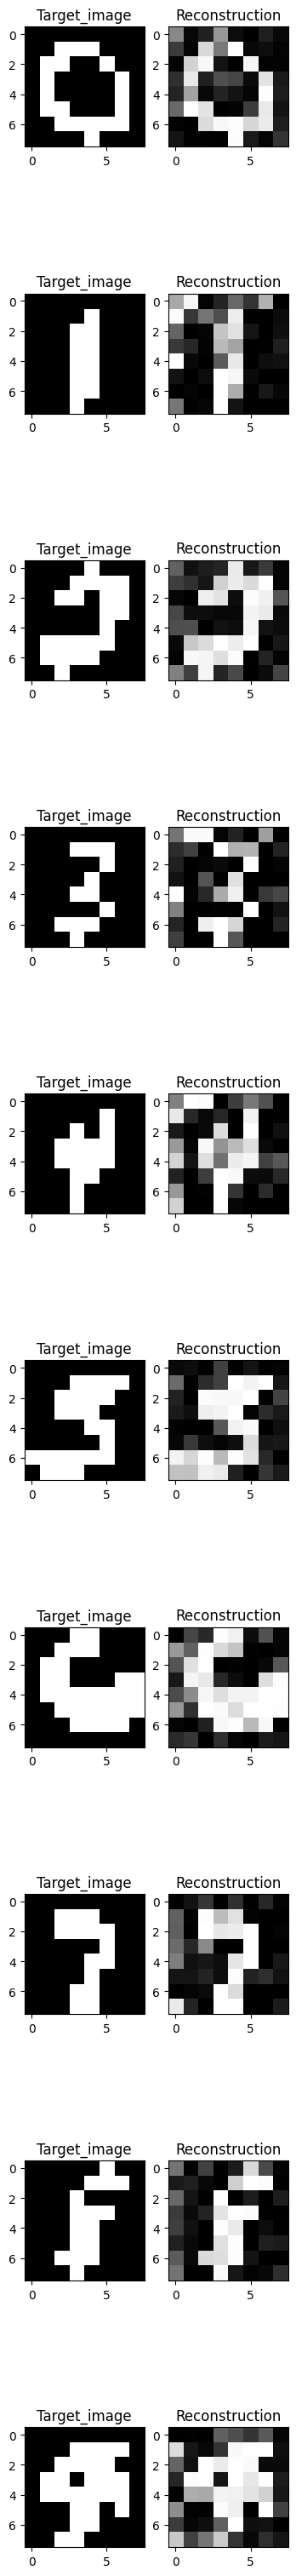

In [19]:
nd_recon = np.array(best_reconstructed_total)
target_mnist, collected_mnist = mnist_total(target_path, collected_path)
image_display(10, target_mnist, nd_recon, size=8)